### Figures for article 'Is the Fate of Deep Convective Systems written form the start?'

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
import joblib
from scipy.stats import gaussian_kde
from scipy.stats import percentileofscore
import cartopy.crs as ccrs
import xarray as xr

/home/b/b381993/miniconda3/envs/pytorch2/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:29: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
def get_images_from_mcs_idx(mcs_idx, list_var, with_labels=False):
    mcs, utime_list, lat_list, lon_list, label_mcs = list_valid_mcs_2[mcs_idx], utc_list_all[mcs_idx], lat_list_all[mcs_idx], lon_list_all[mcs_idx], label_all[mcs_idx]
    
    X_all = np.zeros((len(list_var), len(utime_list), 128,128))
    
    for idx_time in range(len(utime_list)):
        path_dyamond_dir_utc_time = generate_dyamond_file_path_from_utc(utime_list[idx_time], df_relation_table_UTC=df_relation_table)
        path_toocan_file_utc_time = generate_img_seg_file_path_from_utc(utime_list[idx_time], df_relation_table_UTC=df_relation_table)
        lat, long =  lat_list[idx_time], lon_list[idx_time] 
        for i_var, var in enumerate(list_var):
            if var =='MCS_segmentation_mask_only' : 
                    file_path = os.path.join(DeepDyamond.config.PATH_SEGMENTED_IMGS, path_toocan_file_utc_time)
                    X = open_xarray_rolling_lon(file_path = file_path, 
                                                lat_bary = lat, 
                                                lon_bary = long, 
                                                lat_delta = lat_delta_degrees, 
                                                lon_delta = lon_delta_degrees, 
                                                output_shape = (lat_delta_pixels, lon_delta_pixels),
                                                keys_sel=('latitude', 'longitude'))
                    
                    X = binary_segmentation_mask_processing(data = X, label = label_mcs, transparency=True)
                    X=np.mod(X,15)
            elif var =='MCS_segmentation' :
                    file_path = os.path.join(DeepDyamond.config.PATH_SEGMENTED_IMGS, path_toocan_file_utc_time)
                    X = open_xarray_rolling_lon(file_path = file_path, 
                                                lat_bary = lat, 
                                                lon_bary = long, 
                                                lat_delta = lat_delta_degrees, 
                                                lon_delta = lon_delta_degrees, 
                                                output_shape = (lat_delta_pixels, lon_delta_pixels),
                                                keys_sel=('latitude', 'longitude'))
                    X[X==0]=np.nan
                    #X[X==1]=label_mcs
                    if not with_labels:
                        X=np.mod(X,15)
                    else:
                        None
                    
            else:
                    file_path = os.path.join(DeepDyamond.config.PATH_DYAMOND_ROOT_DIR,path_dyamond_dir_utc_time +'.'+var+'.nc')
                    X = open_xarray_rolling_lon(file_path = file_path, 
                            lat_bary = lat, 
                            lon_bary = long, 
                            lat_delta = lat_delta_degrees, 
                            lon_delta = lon_delta_degrees, 
                            output_shape = (lat_delta_pixels, lon_delta_pixels),
                            keys_sel=('lat', 'lon'))
                    
                    
            X_all[i_var, idx_time, :,:]= X
            
    return X_all
                    

In [3]:
import h5py
filename = '/work/bb1153/b381993/data/FINAL_VERSION_AUGUST_new/DEEPFATE_DATASET.h5'
index=500
with h5py.File(filename, 'r') as f:
    images_i = f['X'][index]
    specs_i = f['z'][index]

In [4]:
X_all = images_i

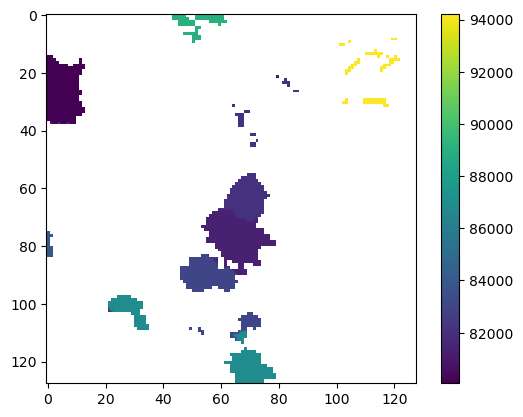

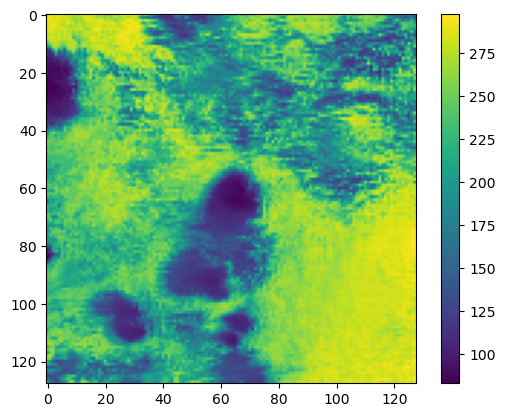

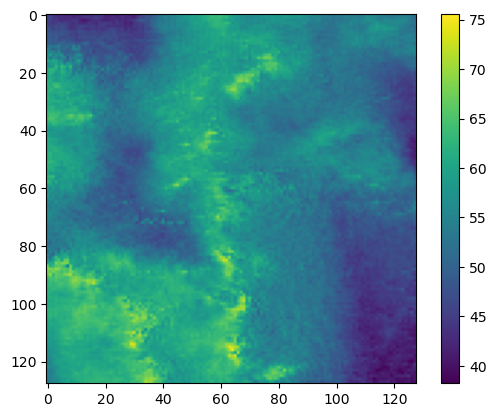

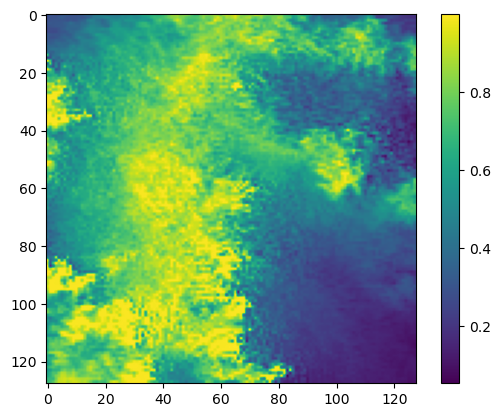

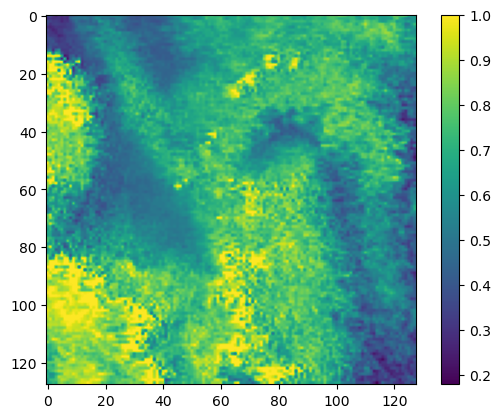

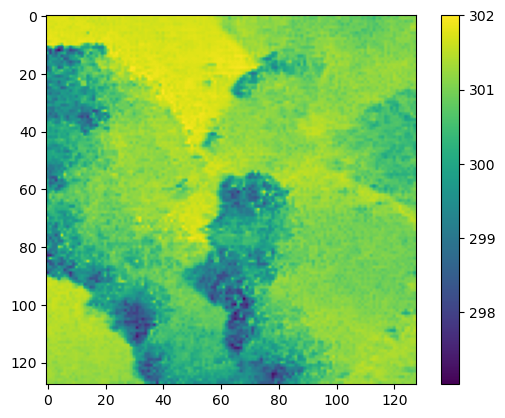

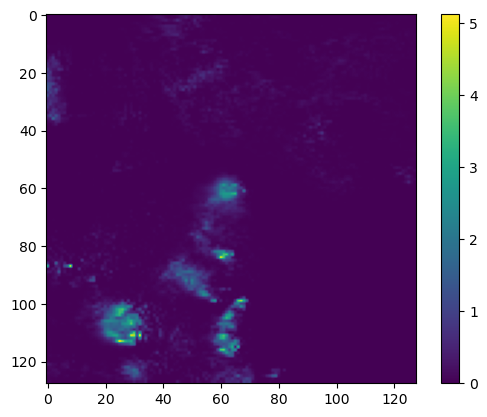

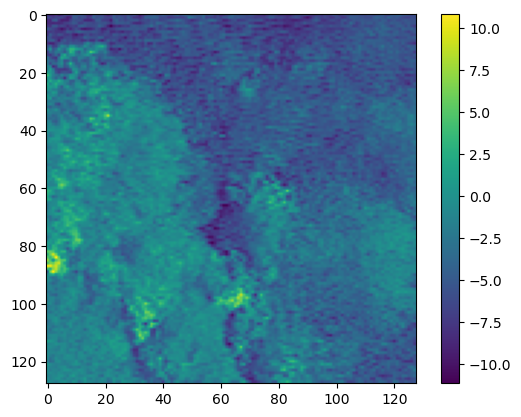

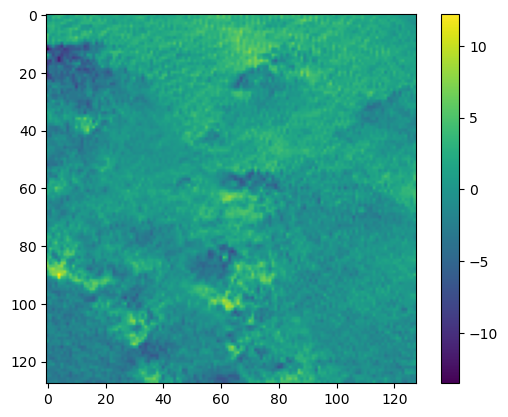

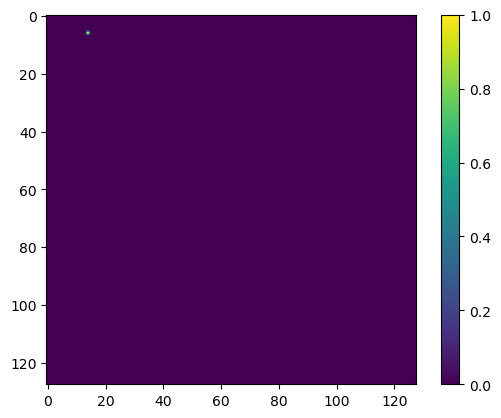

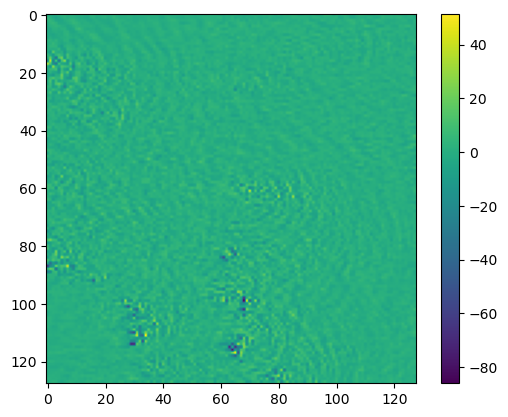

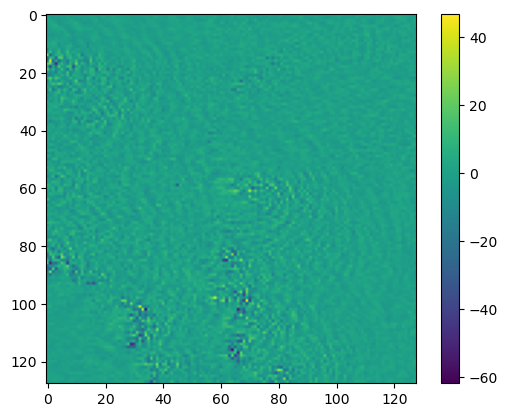

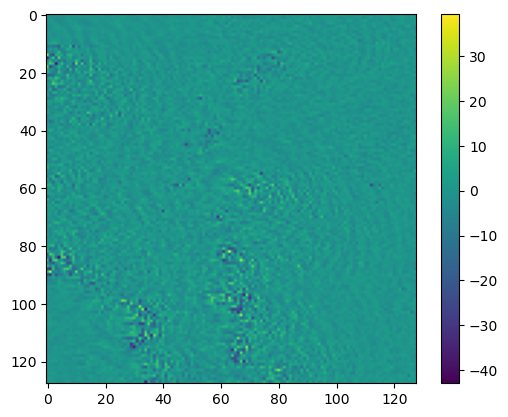

In [5]:
for i in range(13):
    plt.imshow(images_i[2,i,:,:])
    plt.colorbar()
    plt.show()

In [6]:
VARIABLE_PLOT = 'PW'
FULL_NAME_VARIABLE = 'Precipitable Water [mm]'
LATITUDE_SLICE = slice(-40, 40) #degrees
LONGITUDE_SLICE = slice(90, 270)
var = VARIABLE_PLOT
lat_slice = LATITUDE_SLICE
lon_slice=LONGITUDE_SLICE
ROLLING_PIXELS_LON = 4608 #9216/2 corresponds to 180 to be centered to 0°
LON_1, LON_2, LAT_1, LAT_2 = (90.01952, 269.98047, -39.995008, 39.995008)
IMG_EXTENT = ( LON_1-180, LON_2-180, LAT_2, LAT_1)
MODULO_MCS_SEG = 15
COLORBAR_TICKS = np.arange(10,71,1)
CMAP_MCS = plt.cm.get_cmap('gist_ncar', 16)



In [7]:
from DeepFate import config

In [8]:
def get_data_dyamond_toocan(i:int, path_relation_table = config.PATH_RELATION_TABLE):

    rel_table = pd.read_csv(config.PATH_RELATION_TABLE).sort_values(by='UTC_sec')

    UTC = rel_table.iloc[i]['UTC_sec']
    path_dyamond = rel_table.iloc[i]['path_dyamond']
    img_seg_path = rel_table.iloc[i]['img_seg_path']


    path_file_dyamond_pw = os.path.join(config.PATH_DYAMOND_ROOT_DIR, path_dyamond)+'.'+var+'.2D.nc'
    path_file_toocan = os.path.join(config.PATH_SEGMENTED_IMGS, img_seg_path)
    
    print('aaa', path_file_dyamond_pw)
    PW_dyamond = xr.open_dataarray(path_file_dyamond_pw).roll(lon=ROLLING_PIXELS_LON).sel(lat=lat_slice, lon=lon_slice)[0]
    PW_np = PW_dyamond.values
    
    print('bb', path_file_toocan)
    img_seg = xr.open_dataset(path_file_toocan).cloud_mask.roll(longitude=4608).sel(latitude = lat_slice, longitude=slice(90,270))[0]
    img_seg_np = img_seg.values
    img_seg_np_mod = np.mod(img_seg_np,MODULO_MCS_SEG)
    
    return PW_np, img_seg_np_mod


aaa /fastdata/ka1081/DYAMOND/data/summer_data/SAM-4km/OUT_2D/DYAMOND_9216x4608x74_7.5s_4km_4608_0000240720.PW.2D.nc


/home/b/b381993/miniconda3/envs/pytorch2/lib/python3.8/site-packages/xarray/backends/plugins.py:64: RuntimeWarning: Engine 'cfgrib' loading failed:
ecCodes library not found using ['eccodes', 'libeccodes.so', 'libeccodes']
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


bb /work/bb1153/b381993/data3/data/data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.08/GLOBAL/2016/2016_08_21/mcs_mask_TOOCAN_SAM_20160821-043.nc


/home/b/b381993/miniconda3/envs/pytorch2/lib/python3.8/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'cloud_mask' has multiple fill values {-999.0, -998.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/b/b381993/miniconda3/envs/pytorch2/lib/python3.8/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'mcs_mask' has multiple fill values {-999.0, -998.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


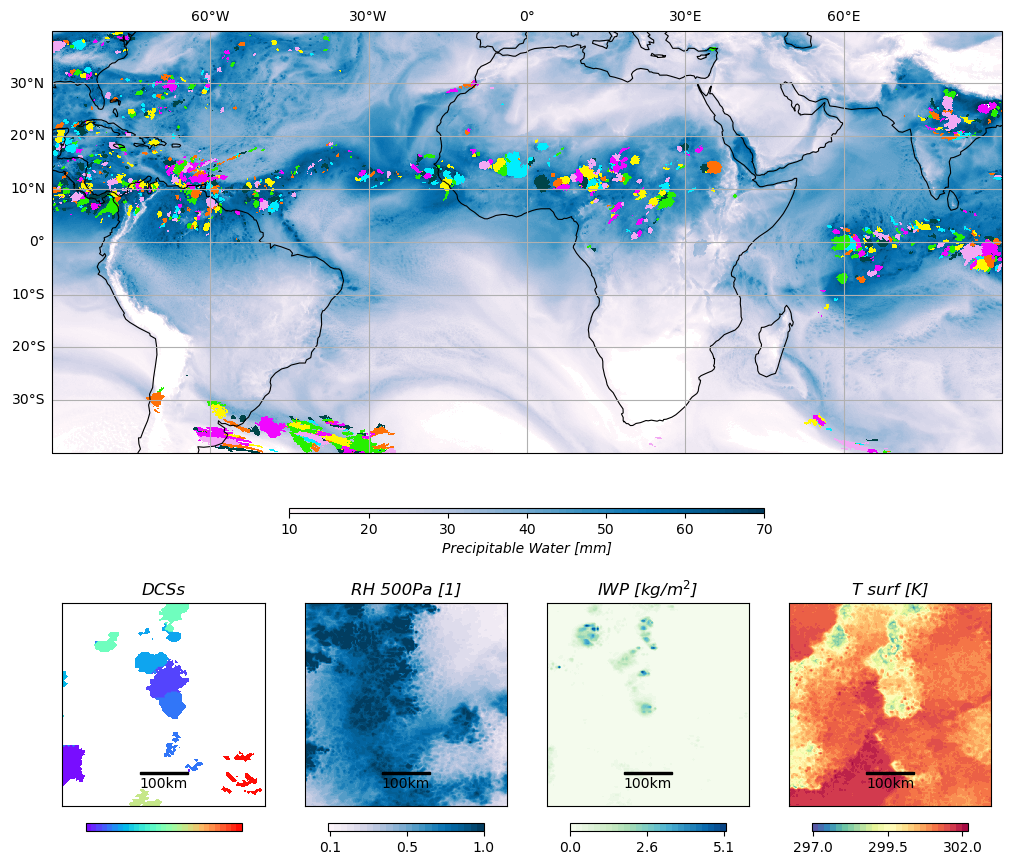

In [9]:
i_time = 2
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

from matplotlib.gridspec import GridSpec

fig = plt.figure(layout="constrained",  figsize=(10,9))

gs = GridSpec(140, 12, figure=fig)

ax1 = fig.add_subplot(gs[100:, :3])
ax2 = fig.add_subplot(gs[100:, 3:6])
ax3 = fig.add_subplot(gs[100:, 6:9])
ax4 = fig.add_subplot(gs[100:, 9:])
ax = fig.add_subplot(gs[:97, :], projection=ccrs.PlateCarree())





cmap_list=['rainbow',  'PuBu', 'GnBu','Spectral_r',  ]#'Greys', 'PuBuGn',  'Spectral', 'GnBu', 'cividis_r']

title_list=['DCSs','RH 500Pa [1]',  'IWP [kg/m$^2$]','T surf [K]']#'LWNTA [W/m$^2$]', 'PW [kg/m$^2$]',  'RH 500hPa [1]', 'OM 700hPa [Pa/s]', 'U surf [m/s]',  ]


list_var = ['MCS_segmentation_mask_only',
            'MCS_segmentation',
           'IWP.2D', 
           'T2mm.2D',]

for i,(iv, axx) in enumerate(zip([0,3, 6,5],[ax1, ax2, ax3, ax4])):
    """    
    j=i%4
    
    if i<4:
        k=0
    elif 3<i<8:
        k=1
    """     
   # print(k,j)
    scalebar = AnchoredSizeBar(axx.transData,
                           30, '100km', 'lower center', 
                           pad=1,
                           color='k',
                           frameon=False,
                           size_vertical=1,
                           )
    
    if title_list[i]=='Neighbours':
        map_X = X_all[i_time,iv,:,:]%10
        im = axx.contourf(map_X, 30, cmap=cmap_list[i], alpha=0.8)
        im2 = axx.contourf(X_all[0, i_time,:,:], 30, cmap=cmap_list[i])
        
    else:
        im = axx.contourf(X_all[i_time,iv,:,:], 30, cmap=cmap_list[i])
        
       
    vmin_im, vmax_im = np.min(X_all[i_time,iv,:,:]), np.max(X_all[i_time,iv,:,:])
    t = np.linspace(vmin_im, vmax_im, 3)
    axx.add_artist(scalebar)
    axx.set_xticks([])
    axx.set_yticks([])
    axx.set_title(title_list[i], fontstyle='italic')
    
    
    
    if (title_list[i]!='MCS') and (title_list[i]!='Neighbours'):
        
        #divider = make_axes_locatable(ax[k,j])
        #cax = divider.append_axes('bottom', size='5%')#, pad=0.05)
        
        cb = fig.colorbar(im, ax=axx, orientation='horizontal',  ticks=t, aspect=20, shrink=0.7, format='%.1f')
    axx.set_aspect('equal')
    

#path_figures = '/work/bb1153/b381993/Figures_for_mcs_dyamond_paper'   
#path_fig = os.path.join(path_figures, 'example_window_sys_variables.pdf')
#plt.savefig(path_fig)



############ bottom plot

#get data
i_0=1000
PW_np, img_seg_np_mod = get_data_dyamond_toocan(i= i_0, path_relation_table = config.PATH_RELATION_TABLE)


#create artists
im = ax.contourf(PW_np, COLORBAR_TICKS, origin='upper', extent=IMG_EXTENT,transform=ccrs.PlateCarree(),cmap='PuBu', vmin=10, vmax=70)

im2 = ax.contourf(img_seg_np_mod, origin='upper', extent=IMG_EXTENT, transform=ccrs.PlateCarree(),cmap = CMAP_MCS)
ax.coastlines(resolution='110m',color='black', linewidth=0.8)

#create colorbar
cb=plt.colorbar(im, shrink=0.5, aspect=100, orientation='horizontal', pad = 0.1, ticks=COLORBAR_TICKS[::10])
cb.set_label(label=f'{FULL_NAME_VARIABLE}', fontstyle='italic')

#add grid_lines
gl = ax.gridlines(draw_labels=True)
gl.bottom_labels = False
gl.right_labels = False




In [10]:
from DeepFate.datasets.generate_precomputed_datasets import get_specs_mcs, get_z_data
from DeepFate.datasets.utils import get_list_valid_mcs
from DeepFate.datasets.utils import get_validity_lifecycles_start_end


import DeepFate
from DeepFate import config
from DeepFate.datasets.load_toocan_dyamond import load_TOOCAN_DYAMOND

list_object_mcs = load_TOOCAN_DYAMOND(DeepFate.config.PATH_TOOCAN_GLOBAL_FILE)

list_valid_mcs = get_list_valid_mcs(list_object_mcs = list_object_mcs,
                   max_area=DeepFate.config.MCS_SPECS_RANGE['max_area'][1],
                    min_area=DeepFate.config.MCS_SPECS_RANGE['max_area'][0],
                    duration_max = DeepFate.config.MCS_SPECS_RANGE['duration_hour'][1], #now in hours
                    duration_min = DeepFate.config.MCS_SPECS_RANGE['duration_hour'][0],
                    lat_max=DeepFate.config.MAX_LAT_TROPICS,
                    )

print(len(list_valid_mcs))
validitity, start_times, end_times = get_validity_lifecycles_start_end(list_valid_mcs)
list_valid_mcs_2 = [list_valid_mcs[i] for i in range(len(list_valid_mcs)) if validitity[i] is True]
list_start_times = [start_times[i] for i in range(len(list_valid_mcs)) if validitity[i] is True]
list_end_times = [end_times[i] for i in range(len(list_valid_mcs)) if validitity[i] is True]

print(len(list_valid_mcs_2))


100%|██████████| 63383/63383 [00:00<00:00, 91784.98it/s]


34617


100%|██████████| 34617/34617 [00:02<00:00, 16458.29it/s]

22405


In [11]:
def get_specs_mcs2(object_mcs, start_time, end_time):
    
    nb_timesteps = DeepFate.config.NB_TIMESTEPS # 6 but previously 10
    
    if (end_time - start_time)<(nb_timesteps-1):
        print('ERROR no')
    
    if len(object_mcs.clusters.LC_UTC_time) < nb_timesteps:
        raise ValueError(' len(object_mcs.clusters.Utime) <= nb_timestep')
    
    if len(object_mcs.clusters.LC_lon) < nb_timesteps:
        raise ValueError(' len(object_mcs.clusters.Utime) <= nb_timestep')
    
    duration_mcs = (int(end_time) - int(start_time) + 1 )*0.5 # in hours
    idx_max = np.argmax(object_mcs.clusters.LC_surfkm2_235K)
    if not start_time<idx_max<end_time:
        print('ERROR', start_time, idx_max, end_time)
        raise ValueError('max not in start -> end')
        
    max_extend = np.sqrt(np.max(object_mcs.clusters.LC_surfkm2_235K))
    
    idx_max_extension = np.argmax(object_mcs.clusters.LC_surfkm2_235K)
    delta_time_max_extension = (int(idx_max_extension) - int(start_time))/2
    
    dict_specs_mcs = {'label_toocan_mcs':object_mcs.DCS_number,
                        'utc_list_mcs':object_mcs.clusters.LC_UTC_time[start_time:end_time],
                        'lat_list_mcs':object_mcs.clusters.LC_lat[start_time:end_time],
                        'lon_list_mcs':object_mcs.clusters.LC_lon[start_time:end_time],
                        'surf_km_list_mcs':object_mcs.clusters.LC_surfkm2_235K[start_time:end_time],
                        'duration_mcs':duration_mcs,
                        'average_velocity':object_mcs.clusters.LC_velocity[start_time:end_time],
                        'classif_JIRAK' : object_mcs.INT_classif_JIRAK,
                        'dist' : object_mcs.INT_distance,
                      'max_extend' : max_extend,
                      'delta_time_maximal_extension' : delta_time_max_extension
                     }
    if object_mcs.DCS_number<100:
        raise ValueError(f'{dict_specs_mcs}')
    assert len(set([len(dict_specs_mcs['utc_list_mcs']),
                   len(dict_specs_mcs['lat_list_mcs']),
                   len(dict_specs_mcs['lon_list_mcs']),
                   len(dict_specs_mcs['surf_km_list_mcs'])])) == 1

    return dict_specs_mcs

In [12]:
df_train = pd.read_csv('/work/bb1153/b381993/data/FINAL_VERSION_new/train_dataset.csv')

In [13]:
duration_list, surf_list = df_train['y_duration'], df_train['y_max_extend']

x=duration_list
y = surf_list
xy = np.vstack([x,y])
z_train = gaussian_kde(xy)(xy)


(40.0, 250.0)

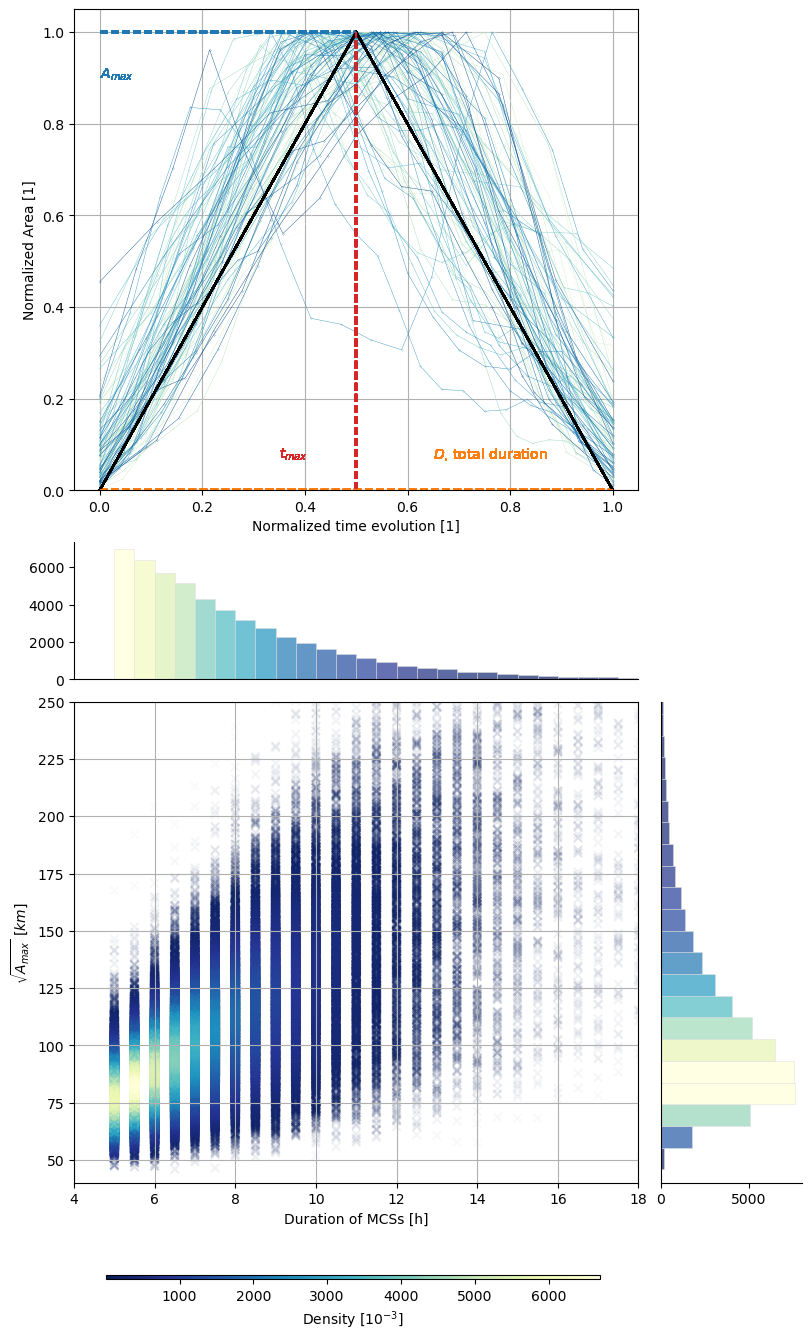

In [14]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(layout="constrained",  figsize=(8,15))

gs = GridSpec(20,10, figure=fig)

ax1 = fig.add_subplot(gs[ :7, :-2])
ax_histx = fig.add_subplot(gs[ 7:9, :-2])
ax = fig.add_subplot(gs[9:-4, :-2])
ax_histy = fig.add_subplot(gs[9:-4, -2:])
cbax = fig.add_subplot(gs[-2:-1,:-2])



######## top panel
cmap_ax1 = plt.get_cmap('GnBu')
for mcs_idx in range(300,400):
    color = (mcs_idx-300)/(400-300)
    mcs, start_time, end_time = list_valid_mcs_2[mcs_idx], list_start_times[mcs_idx], list_end_times[mcs_idx]
    dict_mcs = get_specs_mcs2(object_mcs=mcs, start_time= start_time, end_time= end_time)

    list_area = dict_mcs['surf_km_list_mcs']
    list_area =list_area / np.max(list_area)
    x_axis = np.linspace(0,1, len(list_area))
    
    ax1.plot(np.linspace(0,0.5,10), np.linspace(0,1,10), c='k')
    ax1.plot(np.linspace(0.5,1,10), np.linspace(1,0,10), c='k')
    
    ax1.hlines(1,0,0.5, linestyle='dashed', color='tab:blue')
    ax1.vlines(0.5,0,1, linestyle='dashed', color='tab:red')
    ax1.hlines(0,0,1, linestyle='dashed', color='tab:orange')
    
    
    ax1.text(0,0.9, r'$A_{max}$', color='tab:blue')
    ax1.text(0.35,0.07, r'$t_{max}$', color='tab:red')
    ax1.text(0.65,0.07, r'$D$, total duration', color='tab:orange')
    
    ax1.plot(x_axis, list_area, '.-',c=cmap_ax1(color), linewidth=0.3, ms=0.3)
    ax1.grid(True)

    ax1.set_xlabel('Normalized time evolution [1]')
    ax1.set_ylabel('Normalized Area [1]')
    
    ax1.set_xlim(-0.05,1.05)
    ax1.set_ylim(0,1.05)
    
    
#### bottom panel


m, b = np.polyfit(duration_list, surf_list, 1)

im = ax.scatter(duration_list, surf_list, c=1000*1000*z_train, marker='x', alpha=(z_train/np.max(z_train))**0.5, cmap='YlGnBu_r')
#im = ax.hexbin(duration_list, surf_list, gridsize=30,alpha=0.7, cmap='YlGnBu', vmin=0, vmax=500)
#ax.plot(duration_list, m*np.array(duration_list)+b, color='k', ls='--')
ax.set_xlabel('Duration of MCSs [h]')

ax.set_ylabel(r'$\sqrt{A_{max}}$ [$km$]')
#r = np.round(df_new_with_kde.corr()['duration']['maximal_extension'], 3)
#print(r)
#ax.text(37, 35000, f'r = {r}', color='k')
ax.grid(True)


color=plt.get_cmap('RdYlBu')(0.98)

n, bins, patches = ax_histx.hist(df_train['y_duration'], bins=np.linspace(min(df_train['y_duration']), 22, 35), facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
 
n = n.astype('int') # it MUST be integer
# Good old loop. Choose colormap of your taste
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.YlGnBu_r(n[i]/max(n)))
    #patches[i].set_facecolor(plt.cm.YlGnBu_r(n[i]/np.sum(n)))
    
n, bins, patches = ax_histy.hist(df_train['y_max_extend'], bins=np.linspace(min(df_train['y_max_extend']), max(df_train['y_max_extend']), 60), facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7, orientation='horizontal')

n = n.astype('int') # it MUST be integer
# Good old loop. Choose colormap of your taste
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.YlGnBu_r(n[i]/max(n)))
    
#ax_histy.hist(surf_list, bins=20, orientation='horizontal', alpha=0.7, rwidth=0.85, color=color)
ax_histx.spines[['right', 'top']].set_visible(False)
ax_histy.spines[['right', 'top']].set_visible(False)




fig.colorbar(im, orientation='horizontal', label=r'Density [$10^{-3}$]', aspect=110, ax=cbax)

cbax.remove()

ax_histx.set_xticks([])
ax_histy.set_yticks([])


ax.set_xlim(4,18)
ax_histx.set_xlim(4,18)

ax.set_ylim(40,250)
ax_histy.set_ylim(40,250)



#path_figures = '/work/bb1153/b381993/Figures_PNAS'
#path_fig = os.path.join(path_figures, 'life_cycle.pdf')
#plt.savefig(path_fig)
#LC_UTC_time

(0.0, 400.0)

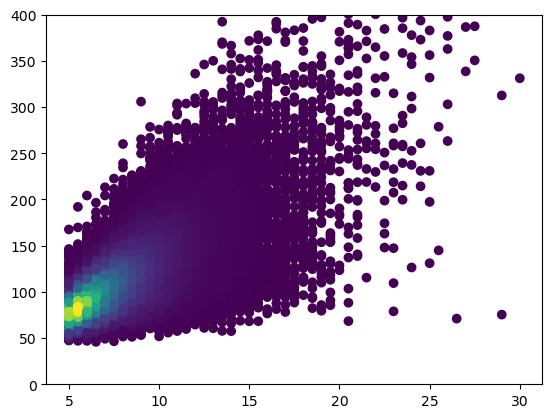

In [16]:
plt.scatter(duration_list, surf_list, c=z_train)
plt.ylim(0,400)

(array([2.8533e+04, 1.3850e+04, 5.7750e+03, 2.2320e+03, 8.1400e+02,
        3.1000e+02, 9.9000e+01, 4.6000e+01, 1.9000e+01, 6.0000e+00]),
 array([ 5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5, 25. , 27.5, 30. ]),
 <BarContainer object of 10 artists>)

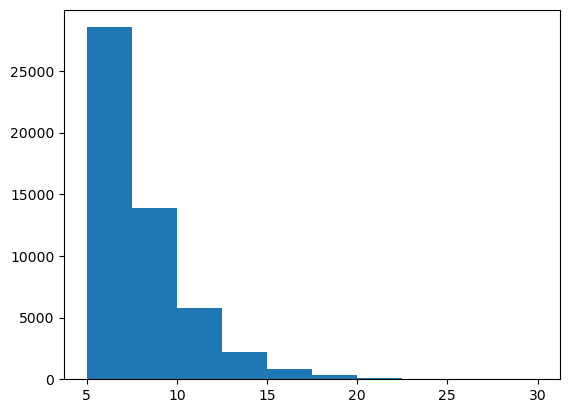

In [15]:
plt.hist(duration_list)

In [22]:
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.YlGnBu_r(n[i]/np.sum(n)))